In [88]:
import pandas as pd
import seaborn as sns
import matplotlib
import matplotlib.pyplot as plt
import json
from collections import OrderedDict
import collections
import ast

In [89]:
# sns.set_palette("pastel")

In [90]:
df = pd.read_csv('games_detailed_info.csv', index_col=0)

C:\Users\janep\AppData\Local\Temp\ipykernel_8840\137549627.py:1: DtypeWarning: Columns (29,48) have mixed types. Specify dtype option on import or set low_memory=False.
  df = pd.read_csv('games_detailed_info.csv', index_col=0)


In [91]:
len(df.columns)

55

### 1. Pandas

1. Проверить данные на наличие пропусков и заполнить их (обосновать выбор метода для заполнения)

Смотрим сколько пропусках в колонках

In [92]:
df.fillna(
    {
        "boardgameartist": "['Anonymous Artists']"

    },
    inplace=True,
)

In [93]:
df.isnull().sum()

type                                 0
id                                   0
thumbnail                           15
image                               15
primary                              0
alternate                        12781
description                          1
yearpublished                        0
minplayers                           0
maxplayers                           0
suggested_num_players                0
suggested_playerage                111
suggested_language_dependence       72
playingtime                          0
minplaytime                          0
maxplaytime                          0
minage                               0
boardgamecategory                  283
boardgamemechanic                 1590
boardgamefamily                   3761
boardgameexpansion               16125
boardgameimplementation          16769
boardgamedesigner                  596
boardgameartist                      0
boardgamepublisher                   1
usersrated               

В некоторых колонках более 50% данных NAN, поэтому дропаем их.

In [94]:
perc = df.isnull().sum()/len(df)
df = df.drop(perc[perc>=0.5].keys(), axis=1)

In [95]:
df.columns

Index(['type', 'id', 'thumbnail', 'image', 'primary', 'description',
       'yearpublished', 'minplayers', 'maxplayers', 'suggested_num_players',
       'suggested_playerage', 'suggested_language_dependence', 'playingtime',
       'minplaytime', 'maxplaytime', 'minage', 'boardgamecategory',
       'boardgamemechanic', 'boardgamefamily', 'boardgamedesigner',
       'boardgameartist', 'boardgamepublisher', 'usersrated', 'average',
       'bayesaverage', 'Board Game Rank', 'stddev', 'median', 'owned',
       'trading', 'wanting', 'wishing', 'numcomments', 'numweights',
       'averageweight'],
      dtype='object')

Также некоторые колонки содержат непонятно что и в названии и по описанию на kaggle

In [96]:
df = df.drop(['boardgamefamily','average','bayesaverage','stddev','median', 'numweights','averageweight'], axis=1)

In [97]:
len(df.columns)

28

2. Проверить данные на наличие выбросов (аномально высоких или низких значений) и устранить выбросы при наличии (обосновать метод для обнаружения выбросов).

C:\Users\janep\AppData\Local\Temp\ipykernel_8840\1371009609.py:3: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `y` variable to `hue` and set `legend=False` for the same effect.

  sns.boxplot(x=df['usersrated'], data=df,  palette="vlag")
C:\Users\janep\AppData\Local\Temp\ipykernel_8840\1371009609.py:13: UserWarning: No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.
  plt.legend(fontsize=12)


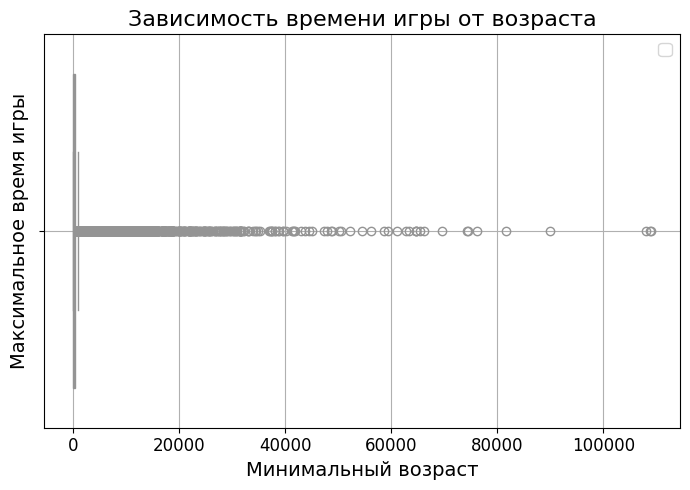

In [98]:
plt.figure(figsize=(7, 5))

sns.boxplot(x=df['usersrated'], data=df,  palette="vlag")

plt.title('Зависимость времени игры от возраста', fontsize=16)
plt.xlabel('Минимальный возраст', fontsize=14)
plt.ylabel('Максимальное время игры', fontsize=14)


plt.xticks(fontsize=12)
plt.yticks(fontsize=12)

plt.legend(fontsize=12)


plt.grid(True)
plt.tight_layout()
plt.show()

3. Произвести фильтрацию.
Вы хотите сравнить количество сериалов с одним, двумя-тремя и четырьмя+ сезонами, отвечая на исследовательский вопрос о том, каких типов сериалов больше.

**Вопрос**: У какого количества различных геймд-художников наибольшее количество игровых механик

**Ответ**: У одиноких.



In [99]:
df['boardgameartist'] = [ast.literal_eval(i) for i in df['boardgameartist']]  # Переводим из строки в массив
df['artists_count'] = df['boardgameartist'].transform(len)  # Создаем дополнительную колонку с количество художников
df.loc[~df['boardgameartist'].isin([['Anonymous Artists']])]['artists_count'].value_counts() # Убираем анонимусов

artists_count
1      9539
2      3463
3      1385
4       534
5       296
6       158
7        67
8        50
9        43
10       26
11       23
12       23
17       10
13       10
15        9
16        8
14        8
21        7
25        4
49        3
22        3
29        3
38        3
18        3
24        3
26        2
53        2
47        2
61        2
33        2
55        2
23        2
48        2
19        2
32        2
69        2
509       1
31        1
86        1
41        1
28        1
145       1
45        1
37        1
57        1
43        1
20        1
85        1
122       1
35        1
27        1
66        1
34        1
84        1
67        1
110       1
103       1
Name: count, dtype: int64

4. Произвести группировку.
Вы группируете сериалы по оценкам и смотрите на их количество, чтобы подтвердить гипотезу о том, что люди в среднем ставят больше всего оценок "хорошо".

**Гипотеза**: Чем ниже минимальный возраст, тем меньше максимальное количество игроков

**Ответ**:

In [110]:
df.groupby('minage')

5. Проанализировать строковые данные.
Вы хотите посмотреть, зависит ли оценка сериала от длины его названия.

In [103]:

df.sort_values(['descriptionlength'])[['descriptionlength','wanting']]

,descriptionlength,wanting
8170,49.0,3
10143,50.0,4
20793,57.0,0
6871,60.0,4
14350,64.0,5
...,...,...
16347,11708.0,5
311,13163.0,348
18960,15551.0,0
21627,16144.0,6


In [104]:
from matplotlib import pyplot as plt
_df_4.plot(kind='scatter', x='descriptionlength', y='wanting', s=32, alpha=.8)
plt.gca().spines[['top', 'right',]].set_visible(False)

NameError: name '_df_4' is not defined

6. Проанализировать временные данные.
Правда ли, что большинство телевизионных сериалов выходит по выходным?

In [18]:
pd.to_datetime(df['yearpublished'])

,yearpublished
0,1970-01-01 00:00:00.000002008
1,1970-01-01 00:00:00.000002000
2,1970-01-01 00:00:00.000001995
3,1970-01-01 00:00:00.000002010
4,1970-01-01 00:00:00.000002008
...,...
21626,1970-01-01 00:00:00.000002020
21627,1970-01-01 00:00:00.000002016
21628,1970-01-01 00:00:00.000001970
21629,1970-01-01 00:00:00.000001989


In [19]:
df['yearpublished'].value_counts() # Расцвет настолок  2015-2019 года

,count
yearpublished,
2017,1325
2018,1321
2016,1291
2019,1258
2015,1147
...,...
1687,1
1150,1
1630,1


### 2. Визуализация

1. Линейный (plot) или точечный (scatter) график.
Один или больше.

In [35]:
len(df['boardgamecategory'].unique())

6731

In [37]:
df.columns

Index(['type', 'id', 'thumbnail', 'image', 'primary', 'description',
       'yearpublished', 'minplayers', 'maxplayers', 'suggested_num_players',
       'suggested_playerage', 'suggested_language_dependence', 'playingtime',
       'minplaytime', 'maxplaytime', 'minage', 'boardgamecategory',
       'boardgamemechanic', 'boardgamedesigner', 'boardgameartist',
       'boardgamepublisher', 'usersrated', 'Board Game Rank', 'owned',
       'trading', 'wanting', 'wishing', 'numcomments'],
      dtype='object')

2. Столбчатые (bar) диаграммы.
Две или больше.

3. Круговая (pie) диаграмма.
Одна или больше.

4. Гистограмма (displot / histplot от seaborn или hist от matplotlib).
Одна или больше.

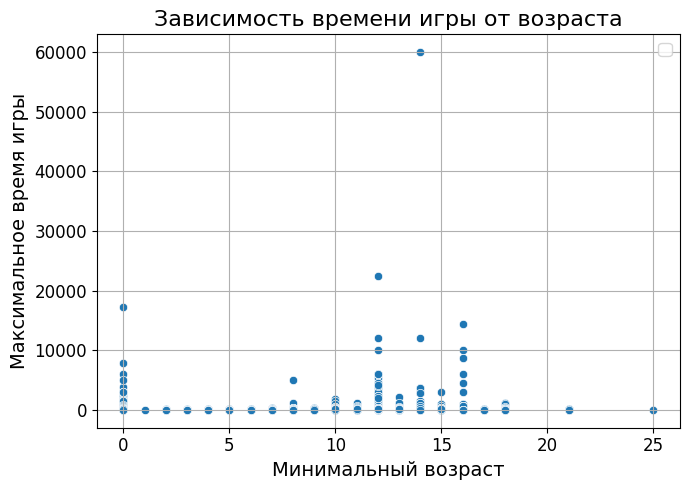

In [20]:
hyp1 = df[['maxplaytime', 'minage']]

plt.figure(figsize=(7, 5))

sns.scatterplot(x="minage", y="maxplaytime", data=hyp1)

plt.title('Зависимость времени игры от возраста', fontsize=16)
plt.xlabel('Минимальный возраст', fontsize=14)
plt.ylabel('Максимальное время игры', fontsize=14)


plt.xticks(fontsize=12)
plt.yticks(fontsize=12)

plt.legend(fontsize=12)


plt.grid(True)
plt.tight_layout()
plt.show()

5. Хитмэп (heatmap).
Один или больше.

6. Облако слов.
Два или больше.

In [ ]:
df['suggested_language_dependence'].eval()

In [ ]:
hyp1 = df[['maxplaytime', 'minage']]

plt.figure(figsize=(7, 5))

sns.stripplot(x="minage", y="maxplaytime", data=hyp1)

plt.title('Зависимость времени игры от возраста', fontsize=16)
plt.xlabel('Минимальный возраст', fontsize=14)
plt.ylabel('Максимальное время игры', fontsize=14)


plt.xticks(fontsize=12)
plt.yticks(fontsize=12)

plt.legend(fontsize=12)


plt.grid(True)
plt.tight_layout()
plt.show()